# Lab 9: Bayesian inference
## Necessary imports and installation

In [ ]:
! sudo apt-get update
! sudo apt-get install texlive-latex-recommended
! sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended
! wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip
! unzip -o type1cm.zip -d /tmp/type1cm
! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins
! sudo mkdir /usr/share/texmf/tex/latex/type1cm
! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm
! sudo texhash

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [773 kB]
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,620 kB]
Get:13 http://archive.ubuntu.com/ubuntu

In [ ]:
!apt install cm-super

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  cm-super-minimal pfb2t1c2pfb
The following NEW packages will be installed:
  cm-super cm-super-minimal pfb2t1c2pfb
0 upgraded, 3 newly installed, 0 to remove and 39 not upgraded.
Need to get 26.0 MB of archives.
After this operation, 59.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 cm-super-minimal all 0.3.4-17 [5,777 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 pfb2t1c2pfb amd64 0.3-11 [9,342 B]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 cm-super all 0.3.4-17 [20.2 MB]
Fetched 26.0 MB in 4s (5,835 kB/s)
Selecting previously unselected package cm-super-minimal.
(Reading database ... 158076 files and directories currently installed.)
Preparing to unpack .../cm-super-minimal_0.3.4-17_all.deb ...
Unpacking cm-super-minimal (0.3.4-17) ...
Selecting

In [ ]:
!pip install latex
!pip install bayesian-optimization

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for latex: filename=latex-0.7.0-py3-none-any.whl size=7588 sha256=de21c78be4d2dd4a39d9621288440d2344783fe0a3b92c7918f9a44c68b78e75
  Stored in directory: /root/.cache/pip/wheels/7e/02/25/c00dfc203e8ba53dfc2e4e97d40e537263d6e03606681f3872
  Created wheel for data: filename=data-0.4-py3-none-any.whl size=7228 sha256=44f7a681adefca10e86b07b69313117b2d47b1399991ab7820a503ad93fbb6d4
  Stored in directory: /root/.cache/pip/wheels/d0/e8/fa/e253c256048ea58d99a8abb5e751abb6a838af6f12887b5418
  Created wheel for shutilwhich: filename=shutilwhich-1.1.0-py3-none-any.whl size=2766 sha256=5254f1b336c89c143ca70ad9ff242fab9d9d58e9fec2ac2d161d91f8d955a03c
  Stored in directory: /root/.cache/pip/wheels/75/1f/1c/0ecab7ceabad0b8e018891505911e82a6f358a0291e7681bae
  Created wheel for tempdir: filename=tempdir-0.7.1-py3-none-any.w

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import sys
from latex import *
from bayes_opt import BayesianOptimization

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install pymc
    !pip install arviz

## Bayesian Inference

Lets say we flip a coin, and get
$h$ heads and $t$ tails, the probability follows a [binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution):
where $D$ is the event of getting $h$ heads and $t$ tails,
$\theta$ is the probability of heads, and $1-\theta$
is the probability of tails. Let say we want to flip the conditional probability using Bayes' theorem:

$$P(\theta|D)=\frac{P(D|\theta)P(\theta)}{P(D)}$$

Why do we want to write the conditional probability this way?

The conditional probability, $P(\theta|D)$, treats the probability of heads,
$\theta$, as a random variable. It is the probability of
$\theta$, given that we observed the event $D$. To make speaking of these probabilies easier they are given names:

$P(\theta)$ - the prior;

$P(\theta|D)$ - the posterior;

$P(D|\theta)$ - the likelihood.



Next, lets look at the prior, $P(\theta)$. This is the probability of $\theta$ before any coin flips. In other words, this is the measure of the belief before we perform the experiment. For the coin flipping example, we normally come across coins that have $\theta=0.5$, so our prior should center around $0.5$. For now, lets pick a [beta distribution](https://en.wikipedia.org/wiki/Beta_distribution) with $\alpha =2$, $\beta=2$ as our prior:
 $$P(\theta)=\frac{1}{B(\alpha, \beta)} {\theta}^{\alpha -1}(1-\theta)^{\beta-1}$$    

Let us derive the closed formula for posterior distribution. Let $t$ denote the number of tails observed and $h$ denote the number of heads observed. Then the likelihood has a binomial distribution:

$$
  P(D|\theta) = C_{h+t}^h \theta^h (1 - \theta)^{t}
$$

Then we can calculate the marginal distribution of the data:
$$
  P(D) = \int_0^1 P(D|\theta)P(\theta) d\theta = \int_0^1 C_{h+t}^h \theta^h (1 - \theta)^{t} \frac{1}{B(\alpha, \beta)} {\theta}^{\alpha -1}(1-\theta)^{\beta-1}d\theta\\
  = \frac{1}{B(\alpha, \beta)} C_{h+t}^h \int_0^1 \theta^{h + \alpha - 1} (1 - \theta)^{t + \beta - 1} d\theta = C_{h+t}^h \frac{B(\alpha + h, \beta + t)}{B(\alpha, \beta)}
$$

Then, finally the posterior is:
$$
  P(\theta | D) = \frac{C_{h+t}^h \theta^h (1 - \theta)^{t} \frac{1}{B(\alpha, \beta)} {\theta}^{\alpha -1}(1-\theta)^{\beta-1}}{C_{h+t}^h \frac{B(\alpha + h, \beta + t)}{B(\alpha, \beta)}} = \frac{1}{B(\alpha + h, \beta + t)} \theta^{\alpha + h - 1} (1 - \theta)^{\beta + t - 1}
$$

and we see that it's again a Beta distribution.

In [ ]:
# PyMC generates a FutureWarning we don't need to deal with yet
import pymc as pm
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
# configure style
mpl.rc('text', usetex=True)
mpl.rc('font', size=26)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

# plt.rcParams['text.usetex'] = True

# mpl.rcParams.update(mpl.rcParamsDefault)

sns.set_style("darkgrid")
sns.set_context("talk", rc={"figure.figsize": (12, 8)}, font_scale=1.0)
current_palette = sns.color_palette()

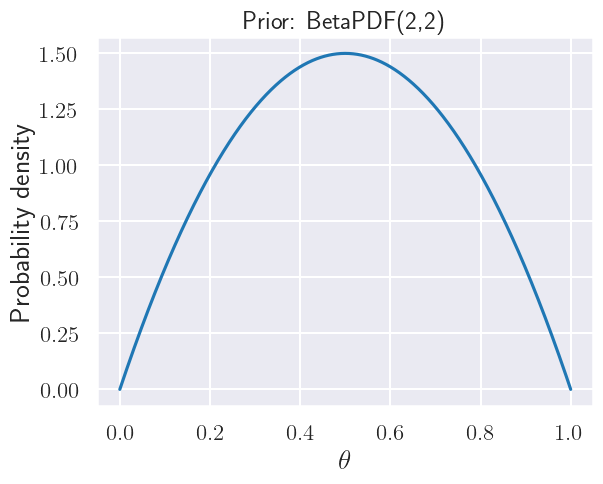

In [ ]:
def plot_prior(alpha, beta, ax=None):
    x = np.linspace(0, 1, 1000)
    y = scipy.stats.beta.pdf(x, alpha, beta)

    if not ax:
        fig, ax = plt.subplots()
    ax.plot(x, y)
    ax.set_xlabel("$\\theta$", fontsize=20)
    ax.set_ylabel("Probability density", fontsize=20)
    ax.set_title("Prior: BetaPDF({},{})".format(alpha,beta))

plot_prior(alpha=2, beta=2)

## $P(D)$

The last thing we need to get the posterior is the denominator of bayes theorem, $P(D)$, which is the probability of the event happening. In general, this is calculated by integrating over all the possible values of $\theta$:

$$P(D)=\int_{0}^{1} P(D|\theta)P(\theta)\ d(\theta) \$$

## Putting it together

Lets say we flipped the coin 17 times and observed 5 heads and 12 tails, our posterior becomes:

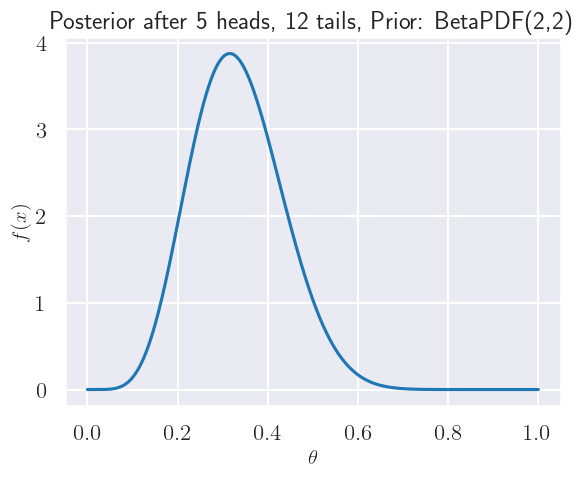

In [ ]:
def plot_posterior(heads, tails, alpha, beta, ax=None):
    x = np.linspace(0, 1, 1000)
    y = scipy.stats.beta.pdf(x, heads+alpha, tails+beta)

    if not ax:
        fig, ax = plt.subplots()
    ax.plot(x, y)
    ax.set_xlabel(r"$\theta$", fontsize=15)
    ax.set_ylabel(r"$f(x)$", fontsize=15)
    ax.set_title("Posterior after {} heads, {} tails, \
                 Prior: BetaPDF({},{})".format(heads, tails, alpha, beta))

plot_posterior(heads=5, tails=12, alpha=2, beta=2)

With $5$ heads and $12$ tails, our belief of the possible values of $\theta$ shifts to the left, suggesting that $\theta$ is more likely to be lower than $0.5$. Now lets say we flipped $75$ times and observed $50$ heads and $25$ tails:

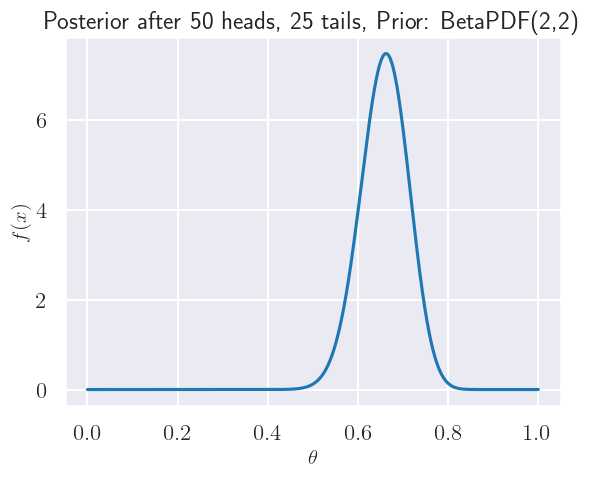

In [ ]:
plot_posterior(heads=50, tails=25, alpha=2, beta=2)

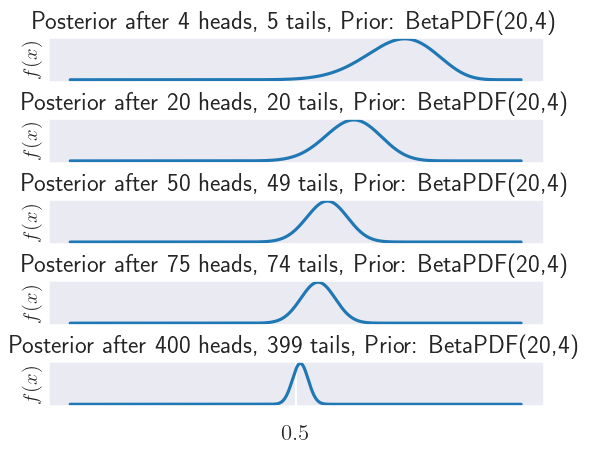

In [ ]:
fig, axes = plt.subplots(5)
flips = [(4, 5), (20, 20), (50, 49), (75, 74), (400, 399)]
for i, flip in enumerate(flips):
    plot_posterior(heads=flip[0], tails=flip[1], alpha=20, beta=4, ax=axes[i])
    axes[i].set_yticks([])
fig.subplots_adjust(hspace=0.8)
for ax in axes:
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_xlabel("")
axes[4].set_xticks([0.5])

## Linear regression

Lets consider the linear regression model. Let $Y$ denote the observed variable that we want to predict using features $X_1$ and $X_2$.

Furrther, suppose that $Y \sim N(\mu, \sigma^2)$. Then $\mu = \alpha + \beta_1 X_1 + \beta_2 X_2$, where $\alpha \sim N(0, 100)$, $\beta_i \sim N(0, 100)$ and $\sigma \sim |N(0, 1)|$.

So, for both regression coefficients we use zero-mean normal distribution with variance 100 and half-normal distribution as a prior for $\sigma$.

In case of the Bayesian linear regression we are constructing we following posterior distribution:

$$
  P(\alpha, \beta, \gamma | Y, X) \propto P(Y | \alpha, \beta, \gamma) P(\alpha) P(\beta) P(\gamma)
$$

### Generating data

In [ ]:
import arviz as az

In [ ]:
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [ ]:
# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0] * X1 + beta[1] * X2 + rng.normal(size=size) * sigma

Lets take a look at generated data:

Text(0.5, 0, 'X2')

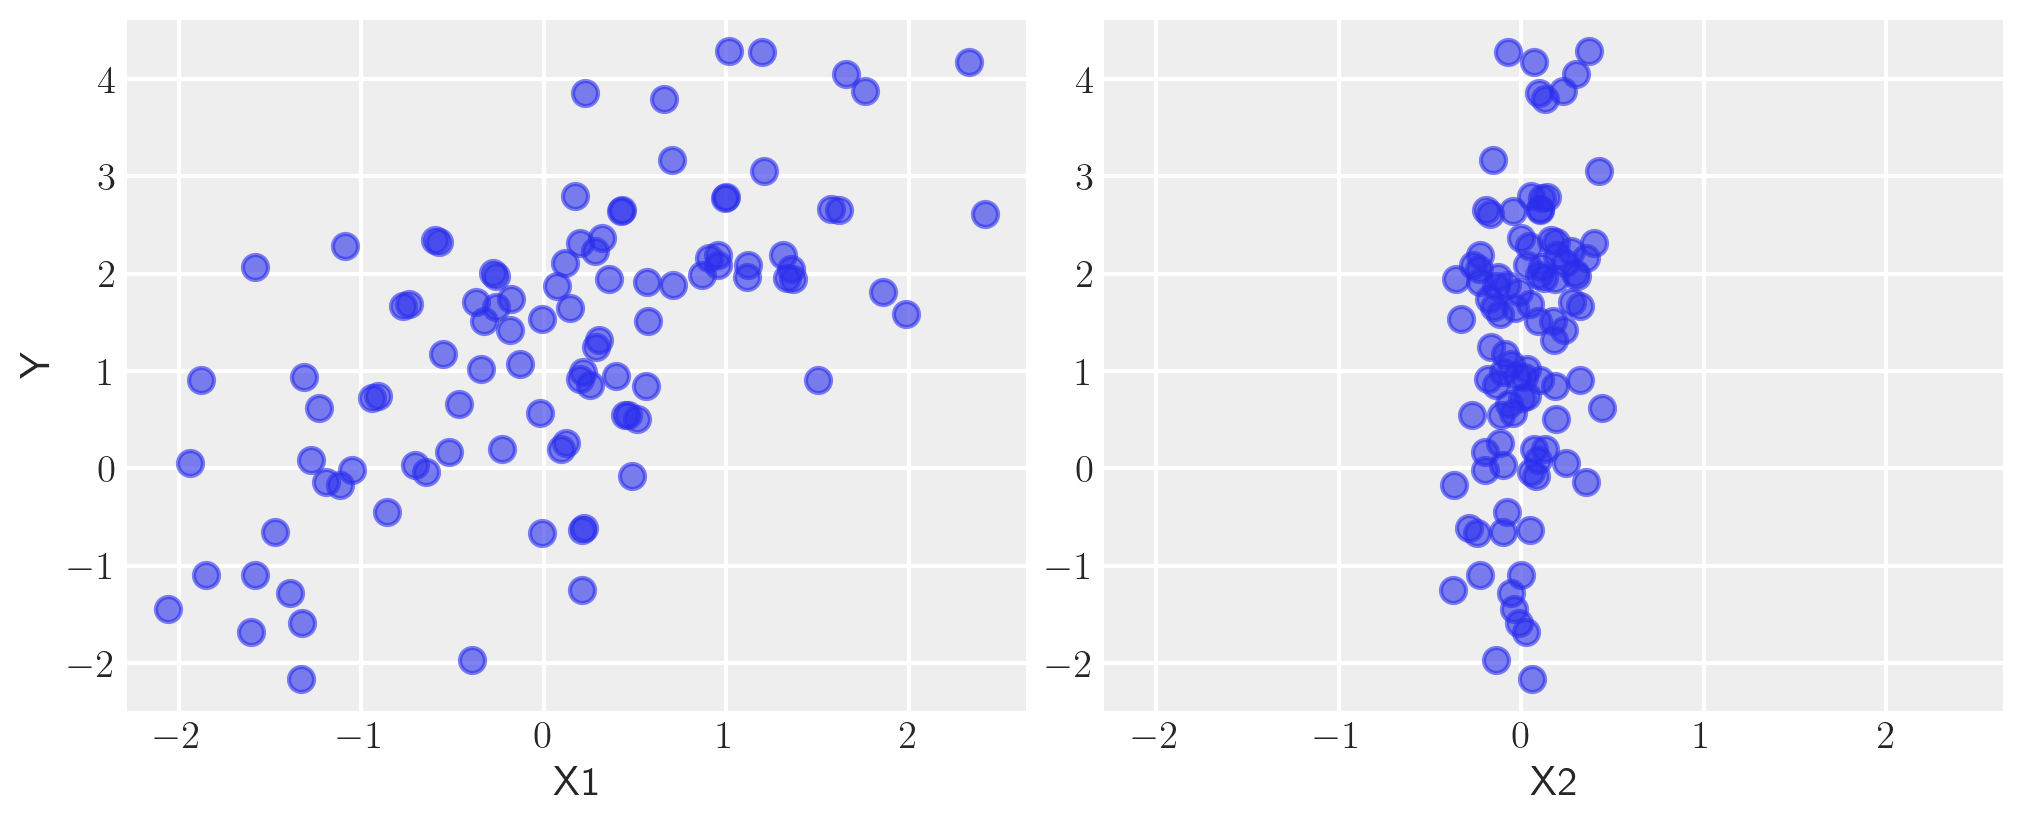

In [ ]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10, 4))
axes[0].scatter(X1, Y, alpha=0.6)
axes[1].scatter(X2, Y, alpha=0.6)
axes[0].set_ylabel("Y")
axes[0].set_xlabel("X1")
axes[1].set_xlabel("X2")

### Model specification

Now lets see how we can define a linear regression model using PyMC library:

In [ ]:
# Create a model
basic_model = pm.Model()

# Within this context manager we can describe relations between random variables
# that we aim to model
with basic_model:
    # Priors for unknown model parameters
    # These three distributions are so called "stochastic" random variables -
    # their is state is only partionally described by their parents.
    # For a convenience the first argument of a consturtor (name of the variable)
    # must be the same as the name of corresponding Python variable.
    # See: https://www.pymc.io/projects/docs/en/latest/api/distributions.html
    # for other supported distributions
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10, shape=2)
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Expected value of outcome
    # This one is a deterministic RV - it's completely defined by its parents,
    # no matter which values they take. RVs support basic arithmetic operations
    # as well as mathematical functions like sum, sin, exp, dot or inv (of a matrix)
    mu = alpha + beta[0] * X1 + beta[1] * X2

    # Likelihood (sampling distribution) of observations
    # Special case - observed stochastic RV. Model can't change the values of Y_obs
    # Further, parameters of this distribution are deterministic mu and stochastic sigma
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)

Lets also visualise our model:

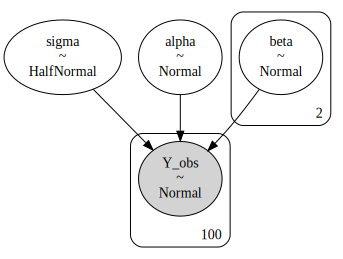

In [ ]:
pm.model_to_graphviz(basic_model)

Lets try to consider 1000 posterior samples from a model:

In [ ]:
with basic_model:
    # draw 1000 posterior samples
    idata = pm.sample(chains=4)

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


In [ ]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

`InferenceData` stores plenty useful information regarding our model, including observed stochastic variable values and convergence related statistics. Lets observe some values for random variable $\alpha$:

In [ ]:
idata.posterior["alpha"].sel(draw=slice(0, 4))

<xarray.DataArray 'alpha' (chain: 4, draw: 5)>
array([[1.13141698, 1.07829558, 1.24265796, 1.11138798, 1.14993154],
       [1.11374527, 1.19356983, 1.12630617, 1.06959057, 1.17856121],
       [1.32996827, 1.23927248, 1.10549414, 1.11117686, 1.24944238],
       [1.0991503 , 1.24291573, 1.07877557, 1.07877557, 1.23262772]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4

### Posterior analysis
 We can analyse posterior destribution of our stochastic variables using Arviz plotting utilities:

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


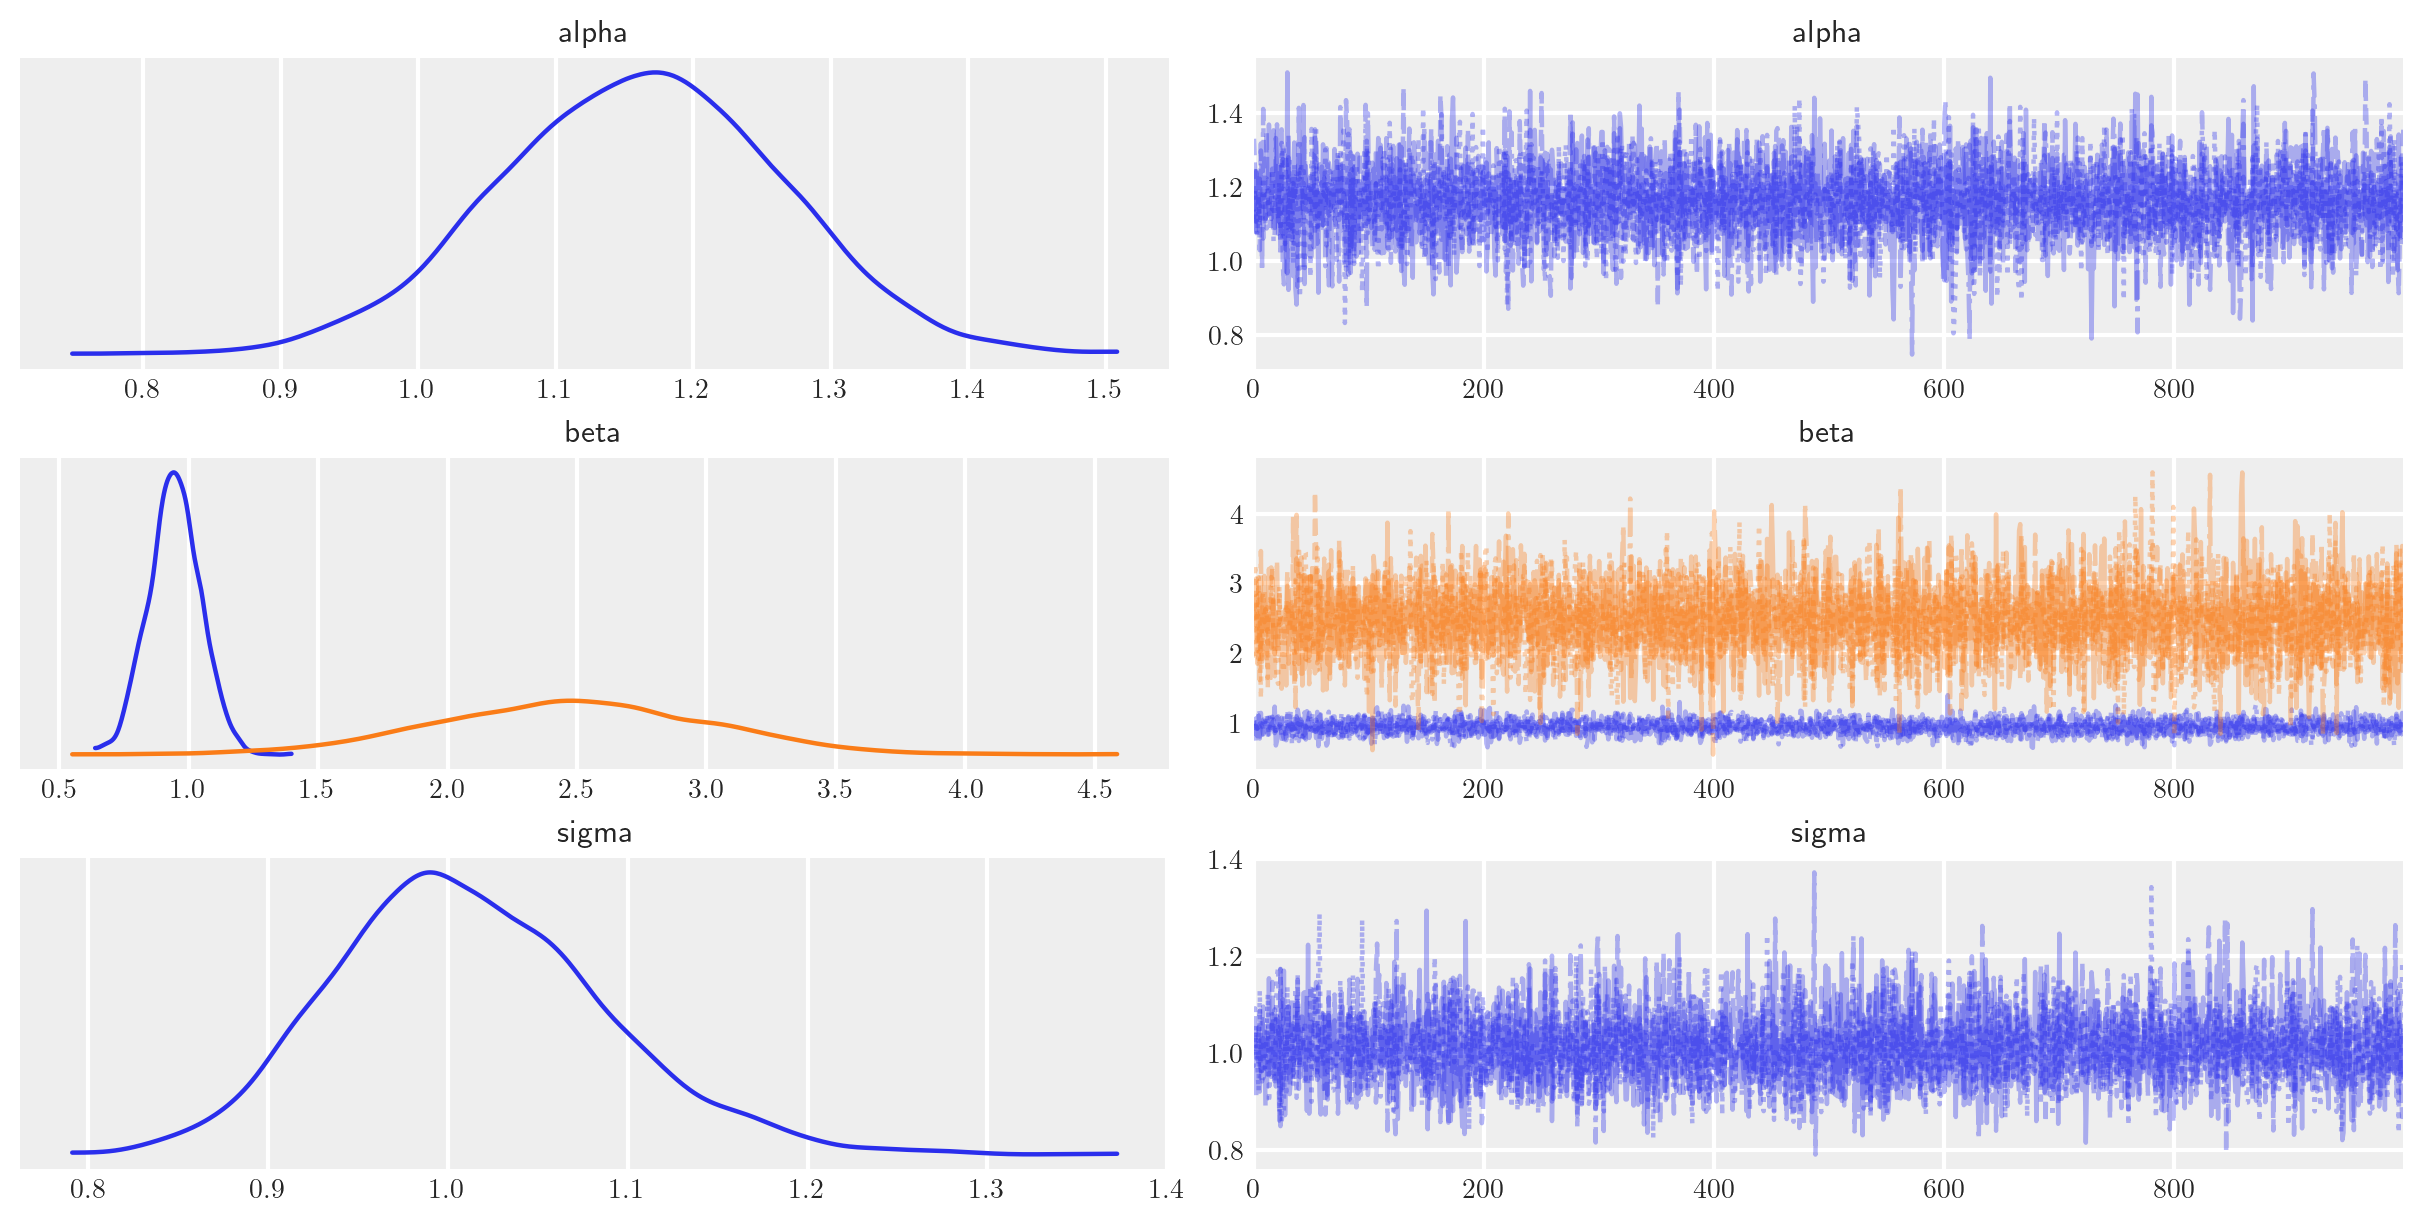

In [ ]:
az.plot_trace(idata, combined=True);

Left plots show a KDE smoothed marginal posteriors of stochastic RVS. Right charts samples from the Markov Chains (more about Markov chains you will see later in a course). Notice that since beta is a vector, it produces 2 marginals and 2 traces.

We can also observe a summary of the posterior statistics:

In [ ]:
az.summary(idata, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.16,0.10,0.97,1.36,0.00,0.00,6084.21,3172.38,1.0
beta[0],0.95,0.10,0.76,1.13,0.00,0.00,5340.14,3084.02,1.0
beta[1],2.48,0.53,1.47,3.45,0.01,0.01,5938.69,3314.00,1.0
sigma,1.01,0.08,0.87,1.15,0.00,0.00,6098.45,3238.88,1.0


## Self-practice task: Logistic regression using PyMC

We are going to try to classify irises. Recall that it has 4 real valued features.

### Loading data

**Task 1.** load iris dataset and select only first two clases and take only first two features.

In [ ]:
from sklearn import datasets

iris = datasets.load_iris()
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_df['target'] = iris.target
iris_df = iris_df.iloc[:, [0, 1, 4]][iris_df["target"] < 2]
iris_df

,sepal length (cm),sepal width (cm),target
0,5.1,3.5,0
1,4.9,3.0,0
2,4.7,3.2,0
3,4.6,3.1,0
4,5.0,3.6,0
...,...,...,...
95,5.7,3.0,1
96,5.7,2.9,1
97,6.2,2.9,1
98,5.1,2.5,1


**Task 2.** draw a scatter plot to check that selected classes are linearly separable.

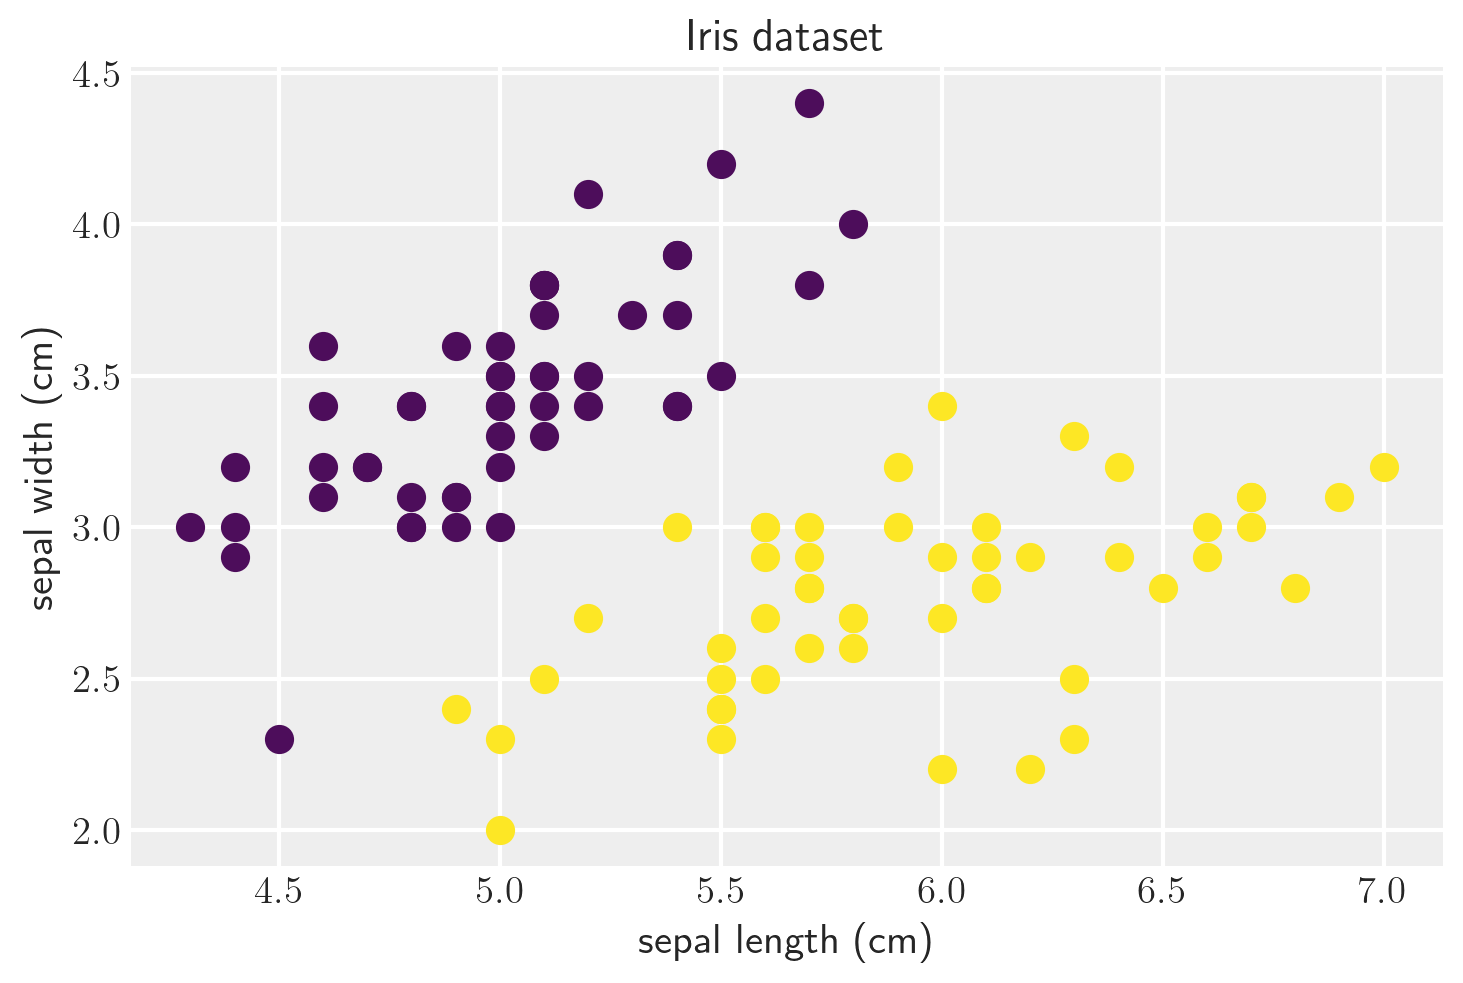

In [ ]:
names = ["setosa", "versicolor"]
colors = ["#4D0D5B", "#FDE725"]

for i in range(2):
  plt.scatter(
      iris_df[iris_df["target"] == i].iloc[:, 0],
      iris_df[iris_df["target"] == i].iloc[:, 1],
      label = names[i],
      color = colors[i]
  )

plt.xlabel(iris_df.columns[0])
plt.ylabel(iris_df.columns[1])
plt.title("Iris dataset");

### Define Logistic regression model

**Task 3**

1. Select apriori distribution for intercept to be normal with mean 0 and variance 100
2. Select apriori distribution for coefficients to be normal with mean 0 and variance 100 (notice that we have 4 of them, so we have to take it into account somehow. Documentation of `pm.Normal` might be useful)
3. Compute linear mu. *Hint:* you might need to check `pm.math` documentation
4. Choose a right distribution for logits. Don't forget to set parameter `observed`.

In [ ]:
# Create a model
basic_model = pm.Model()
X1 = iris_df.iloc[:, 0].to_numpy()
X2 = iris_df.iloc[:, 1].to_numpy()
Y = iris_df["target"].to_numpy()

basic_model = pm.Model()
with basic_model:
    alpha = pm.Normal("alpha", mu=0, sigma=100)
    coefs = pm.Normal("coeffs", mu=0, sigma=10, shape=2)

    mu = alpha + coefs[0] * X1 + coefs[1] * X2

    Y_obs = pm.Bernoulli("logit", logit_p=mu, observed=Y)

**Task 4.** Visualise the model and make sure that it looks correctly:

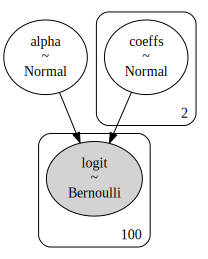

In [ ]:
pm.model_to_graphviz(basic_model)

**Task 5.** Fit the model:

In [ ]:
with basic_model:
    idata = pm.sample(chains=4)

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
ERROR:pymc.stats.convergence:There were 1029 divergences after tuning. Increase `target_accept` or reparameterize.


**Task 6.** plot posterior distributions

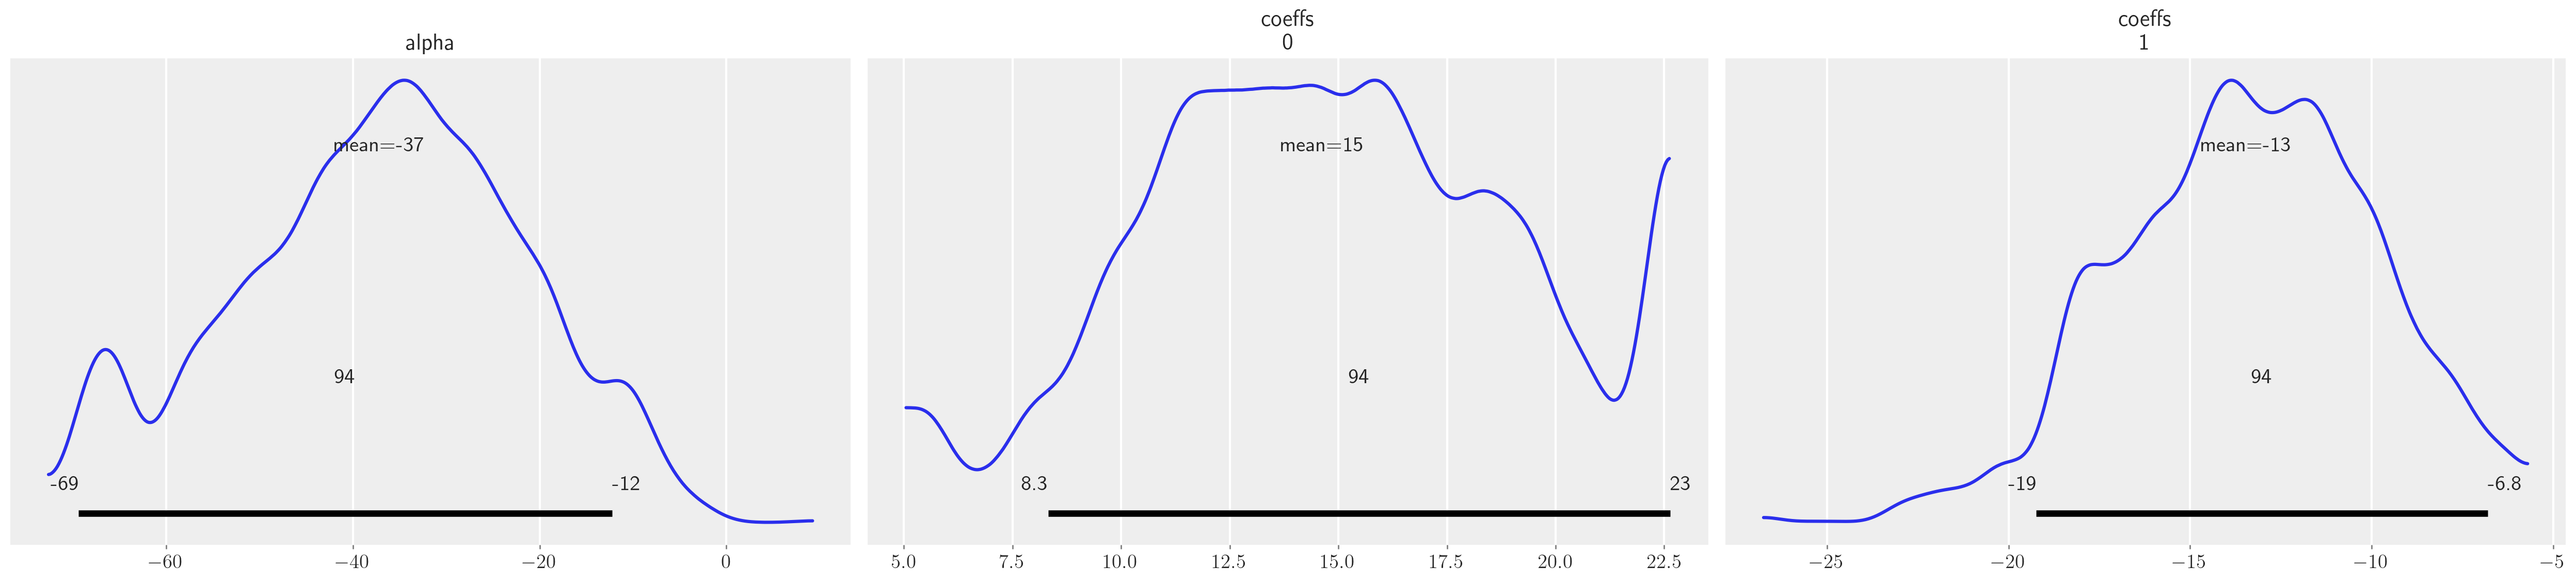

In [ ]:
ax = az.plot_posterior(idata)

**Task 7.** check model summary:

In [ ]:
az.summary(idata, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-37.14,15.37,-69.43,-12.25,3.18,2.54,24.38,24.83,1.12
coeffs[0],14.65,4.05,8.33,22.63,0.83,0.65,21.90,14.15,1.14
coeffs[1],-13.43,3.46,-19.24,-6.81,0.42,0.30,63.63,72.55,1.06
